In [24]:

from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
__all__ = ['parallel_map', 'serial_map', 'loky_pmap', 'mpi_pmap']

import multiprocessing
import os
import sys
import time
import threading
import concurrent.futures
import warnings
from qutip.ui.progressbar import progress_bars
from qutip.settings import available_cpu_count
from scipy.fft import fft, ifft 

import matplotlib.pyplot as plt
import qutip

import numpy as np 
import time 


print("import erfolgreich ")

# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath
print(math.cos(np.pi),np.cos(0))

import erfolgreich 
-1.0 1.0


In [25]:
# Parameters

#kb=1.380649*10**(-23)
#h=1.05457*10**(-34)

w0 = 1 # Alle frequenzen in einheiten der resonanzfrequenz. 
#g = ((1/20)*4*np.pi)**2

# coupling strengt in omega
#steps= 2000
#tmax=10
#tlist = [0, tmax, steps]
kb=h=1
Td=0  #in 1/w0
gamma1=0.1
#g=0.00648
g=0.5



def Temp(omega,n):
    T=h*omega/(kb*(np.log((1/n)+1)))
    return T

def nb(w,t):
    return 1/(np.exp(w/t)-1)


nB=0.04
T=0.5
#T=10 # Einheit von  hb*omega durch kb 
beta = 1. / T
gamma=0.1 # cut off frequency in einheiten  von omega. Steigt mit temperatur. amplitude der noise spielt auch eine rolle 
lam=0.1 #"""Proportional zu g² aber da kommen noch andere faktorren dazu""" # teil der  noise  rate for correlation, 
#lam= (g**2) *(np.log(1) + np.log(gamma))
#lam= g/(4*np.pi)
print(Temp(1,0.00001))
#print("lam=",lam, "T=", T, "gamma=",gamma,"g=",g)


0.08685882093641431


In [26]:
#The system Hamiltonian:
P11=basis(2,0)*basis(2,0).dag()
P22=basis(2,1)*basis(2,1).dag()
P12=basis(2,0)*basis(2,1).dag()
P21=basis(2,1)*basis(2,0).dag()

sm = qutip.tensor(qutip.qeye(2), qutip.destroy(2))

# Initial state of the system:
rho0 = P22


Q=(P12+P21)#*(np.exp(-1j*x) + np.exp(1j*x)))+g*((P12+P21)*(np.exp(+1j*x) + np.exp(-1j*x)))
#H_sys = w0*sigmaz()+g*((P12+P21))#*(np.exp(-1j*x) + np.exp(1j*x)))+g*((P12+P21)*(np.exp(+1j*x) + np.exp(-1j*x)))
sm.dag() * sm
#H_sys=w0*(P21*P12)
H_sys=0.5*w0*sigmaz()
print(P12+P21,basis(2,0))
print(sigmaz())

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]] Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]


In [27]:
#Matsubara zerlegung bad mit drude lorez spektraldichte mal cos(Td*w/2)^2 
def cot(x):
    return 1. / np.tan(x)

beta = 1. / T

# Number of expansion terms to calculate:
Nk = 10

# C_real expansion terms:
ck_real = [lam * gamma *(np.cosh(gamma * Td/2)**2)/ np.tan(gamma / (2 * T))]
ck_real.extend([
    ((np.cosh(2 * np.pi * k * T*Td)**2)*8 * lam * gamma * T * np.pi * k * T /
        ((2 * np.pi * k * T)**2 - gamma**2))
    for k in range(1, Nk + 1)
])
vk_real = [gamma]
vk_real.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag = [lam * gamma * (-1.0)*(np.cosh(gamma*T/2)**2)]
vk_imag = [gamma]
Bad=BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)

In [28]:
#Bad Mey=exp(-w/wc)
# C_real expansion terms:

"""

ck_real = [0]
ck_real.extend([
    (np.exp(1j*2 * np.pi * k * T/gamma)*(np.cosh(2 * np.pi * k * T*tl))**2)
    for k in range(1, Nk + 1)
])
vk_real = [0]
vk_real.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag = [0]
vk_imag = [0]
BadMey = BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)
BadDefault=DrudeLorentzBath(Q, g**2, gamma, T, Nk)
print(ck_real)
"""

'\n\nck_real = [0]\nck_real.extend([\n    (np.exp(1j*2 * np.pi * k * T/gamma)*(np.cosh(2 * np.pi * k * T*tl))**2)\n    for k in range(1, Nk + 1)\n])\nvk_real = [0]\nvk_real.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])\n\n# C_imag expansion terms (this is the full expansion):\nck_imag = [0]\nvk_imag = [0]\nBadMey = BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)\nBadDefault=DrudeLorentzBath(Q, g**2, gamma, T, Nk)\nprint(ck_real)\n'

In [29]:
#Nk=15
c=0; tl=0
# C_real expansion terms:
ck_realf = [(1j*c/gamma1) / np.tan((1j*gamma1+w0)/ (2 * T))*(np.cos(w0+1j*gamma1)*tl)**2, (1j*c/gamma1) / np.tan((-1j*gamma1+w0)/ (2 * T))*(np.cos(w0-1j*gamma1)*tl)**2
]#*np.cosh(gamma*tl)
#ck_realf.append([(1j*c/gamma1) / np.tan((1j*gamma1+w0)/ (2 * T))*(np.cos(w0-1j*gamma1)*tl)**2])
ck_realf.extend([
    (-2*c  * T * np.pi * k * T)*np.cosh(2 * np.pi * k * T*tl)**2/
        ((w0**2 - 4j*k *w0- np.pi- 4* k**2* np.pi**2 +  gamma1**2))
    for k in range(1, Nk + 1)
])
vk_realf = [1j*w0+gamma1,1j*w0-gamma1
]
#vk_realf.append([1j*w0-gamma1])
vk_realf.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imagf = [(1j*c/gamma1 )*np.cos((w0-1j*gamma1)*tl)**2,(-1j*c/gamma1 )*np.cos((w0+1j*gamma1)*tl)**2
]
#ck_imagf.append([(1j*c/gamma1 )*np.cos((w0-1j*gamma1)*tl)**2
#])
vk_imagf = [1j*  w0 - gamma1,1j*w0+gamma1]
#vk_imagf.append([1j*w0-gamma1])
Badf = BosonicBath(Q, ck_realf, vk_realf, ck_imagf, vk_imagf)
print("lam=",lam, "T=", T, "gamma=",gamma,ck_realf)
#Baths=[]
#Baths.append(Bad1)
#Baths.append(Bad2)
print(ck_imagf)

lam= 0.1 T= 0.5 gamma= 0.1 [0j, 0j, (-0-0j), (-0-0j), (-0-0j), (-0-0j), (-0-0j), (-0-0j), (-0-0j), (-0-0j), (-0-0j), (-0-0j)]
[0j, -0j]


def C(tlist,sigma,mu):
    eta_list = []
    gamma_list  =[]
    

    eta_0 = 0.5*Gamma*W*f_approx(1.0j*beta*W)

    gamma_0 = W - sigma*1.0j*mu
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
            gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list
 

def c_t_L_num(t,sigma,mu):
    
    integrand = lambda w: (1/(2*pi))*exp(sigma*1.0j*w*t)*Gamma_w(w,mu)*f(sigma*beta*(w-mu))
    def real_func(x):
        return real(integrand(x))
    def imag_func(x):
        return imag(integrand(x))
    #return quad(integrand,-np.inf,np.inf)[0]
    # This bounds must be increased if W is increased
    # But this integration is quite unstable for large frequencies.
    
    a= -50
    b= 50
    real_integral = quad(real_func, a, b)
    imag_integral = quad(imag_func, a, b)
    return real_integral[0] + 1.0j * imag_integral[0]

In [30]:


tlist = np.linspace(0,5, 100000)


10.0%. Run time:   0.40s. Est. time left: 00:00:00:03
20.0%. Run time:   0.81s. Est. time left: 00:00:00:03
30.0%. Run time:   1.20s. Est. time left: 00:00:00:02
40.0%. Run time:   1.58s. Est. time left: 00:00:00:02
50.0%. Run time:   1.96s. Est. time left: 00:00:00:01
60.0%. Run time:   2.35s. Est. time left: 00:00:00:01
70.0%. Run time:   2.73s. Est. time left: 00:00:00:01
80.0%. Run time:   3.13s. Est. time left: 00:00:00:00
90.0%. Run time:   3.53s. Est. time left: 00:00:00:00
100.0%. Run time:   3.93s. Est. time left: 00:00:00:00
Total run time:   3.93s
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]


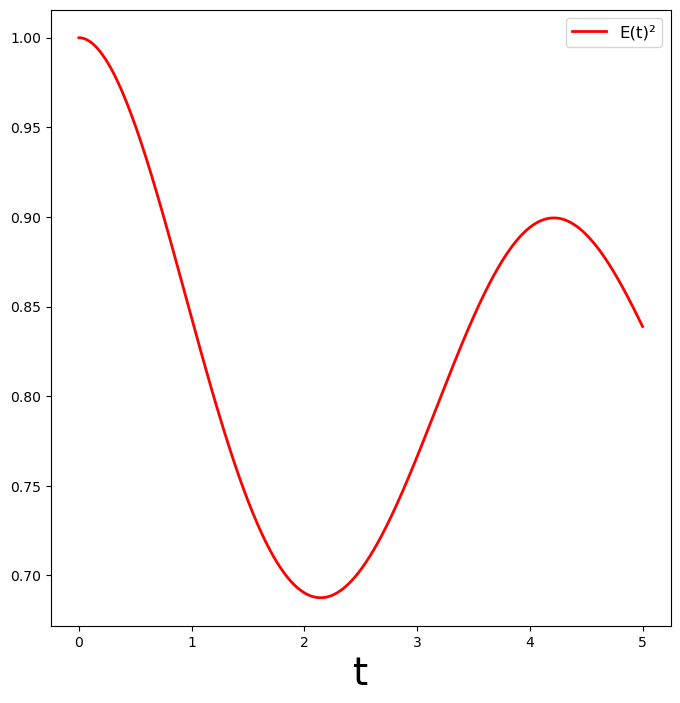

In [31]:

max_depth=2
options = {"nsteps": 1500_000}
#options = Options(atol=1e-2, rtol=1e-2)
#delta, terminator=Bad.terminator()
#HL = liouvillian(H_sys) + terminator
solver = HEOMSolver(H_sys,Bad, max_depth=max_depth, options=options)

#Gibt einen  ausdruck der zeit an. 

# times to evaluate the system state at
#result = solver.run(rho0, tlist)
# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()

# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):


# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()
E=basis(2,1) * basis(2,1).dag()*(basis(2,1) * basis(2,1).dag()).dag()
# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):
P12p = basis(2,0) * basis(2,1).dag()
P21p = basis(2,1) * basis(2,0).dag()
# Run the solver:

result_HEOM = solver.run(rho0, tlist, e_ops={"11": P11p, "21": P21p, "12": P12p, "22": P22p,"E":E})
#result_HEOM = solver.run(rho0, tlist, e_ops={"22": P22p})
# Plot the results:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(result_HEOM.times, result_HEOM.e_data["12"], 'b', linewidth=2, label="12")
#axes.plot(result_HEOM.times, np.imag(result_HEOM.e_data["21"]), 'r', linewidth=2, label="21")
#axes.plot(result_HEOM.times, result_HEOM.e_data["11"], 'g', linewidth=2, label="11")
#axes.plot(result_HEOM.times, result_HEOM.e_data["22"], 'b', linewidth=2, label="22")
axes.plot(result_HEOM.times, (np.abs(result_HEOM.e_data["22"])**2), 'r', linewidth=2, label="E(t)²")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)
print(P22p,E)


Text(0.5, 1.0, 'Solution of the ODE with complex convolution (Python)')

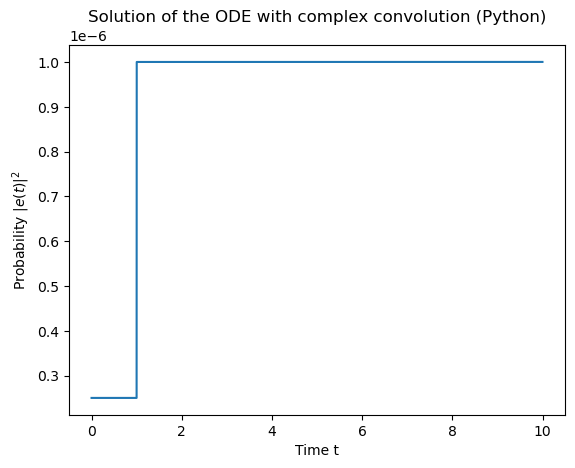

In [32]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.special import cosh, sinh

# Parameters
dt = 0.001
time = np.arange(0, 10, dt)  # Time axis
P_e = np.zeros(len(time), dtype=complex)  # Probability of the excited state
P_e[0] = 1.0  # Initial condition


lam=0.5
gamma=0.001
Td=1
# Correlation function C(t)
def C(t):
    if t >= 0:
        return -0.5j * gamma * lam * (
            2 * np.cosh(t * gamma) * (1 + np.cosh(Td * gamma)) +
            np.cosh((t - Td) * gamma) * (
                np.floor((np.pi - 2 * np.angle(t - Td)) / (4 * np.pi)) -
                np.floor(0.75 + np.angle(t - Td) / (2 * np.pi))
            )
        )
    else:
        return 0.0

# Discretize the correlation function
C_vals = np.array([C(t) for t in time])

# Numerical solution of the differential equation
for k in range(1, len(time)):
    # Compute the convolution
    convolution = np.sum(C_vals[:k] * P_e[k-1::-1]) * dt
    # Update P_e[k]
    P_e[k] = P_e[k-1] -dt*1j*w0*P_e[k-1] -dt * convolution

# Plot the solution
#plt.plot(time, np.abs(P_e)**2, label=r"$|e(t)|^2$")
plt.plot(time,np.abs(C_vals)**2, label=r"$|c(t)| $ " ) 
plt.xlabel("Time t")
plt.ylabel(r"Probability $|e(t)|^2$")
plt.title("Solution of the ODE with complex convolution (Python)")

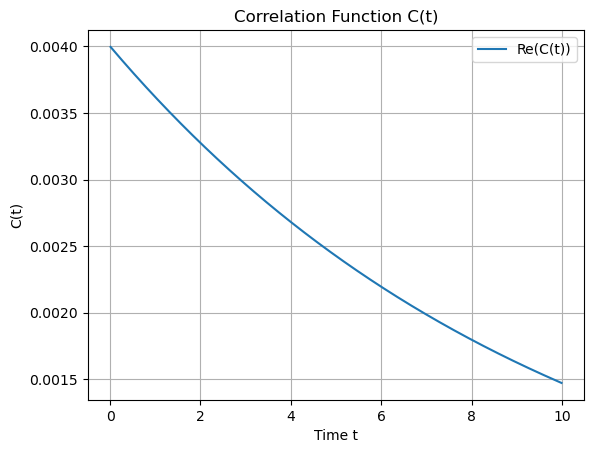

/tmp/ipykernel_5138/2557277423.py:59: RuntimeWarning: invalid value encountered in multiply
  convolution = np.sum(C_vals[:k] * P_e[k-1::-1]) * dt
/tmp/ipykernel_5138/2557277423.py:61: RuntimeWarning: invalid value encountered in scalar multiply
  P_e[k] = P_e[k-1] - dt  * ω0 *1j* P_e[k-1] - dt * convolution
/tmp/ipykernel_5138/2557277423.py:61: RuntimeWarning: invalid value encountered in subtract
  P_e[k] = P_e[k-1] - dt  * ω0 *1j* P_e[k-1] - dt * convolution


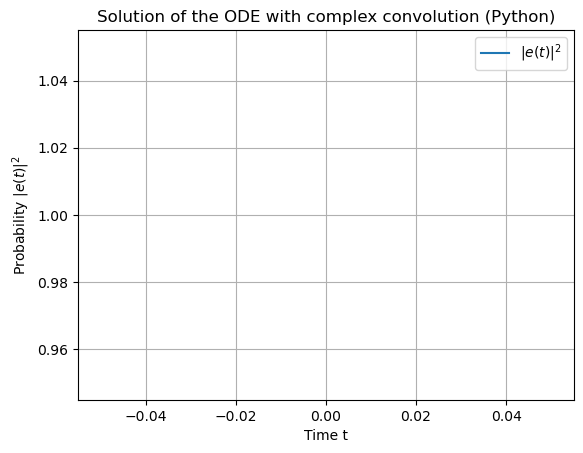

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import shichi
from mpmath import meijerg
#from scipy.integrate import quad

# Parameters
dt = 0.01
time = np.arange(0, 10, dt)  # Time axis
P_e = np.zeros(len(time), dtype=complex)  # Probability of excited state
P_e[0] = 1.0  # Initial condition

lam=0.01
gamma=0.1# Coupling strength
Td = 0  # Delay time
ω0 = 1.0  # Eigenfrequency

# Hyperbolic integrals and Meijer-G function placeholders
def sinhint(x):
    sinh_integral, _ = shichi(x)  # shichi returns (sinhint, coshint)
    return sinh_integral

def coshint(x):
    _,cosh_integral = shichi(x)  # shichi returns (sinhint, coshint)
    return cosh_integral # Simplified placeholder for CoshIntegral

def C(t):
    if t >= 0:
        return (1 / np.pi) * gamma * lam * (
            -2j * np.exp(-t * gamma) * np.pi +
            (np.exp(-t * gamma) + np.exp(t * gamma)) * coshint(t * gamma) +
            np.sqrt(np.pi) * meijerg([[0], []], [[0, 0], [1/2]], (t**2 * gamma**2) / 4) -
            1j * np.exp(-gamma * np.abs(t - Td)) * np.pi * np.sign(t - Td) -
            1j * np.exp(-(t + Td) * gamma) * np.pi * np.sign(t + Td) +
            np.exp(-t * gamma) * sinhint(t * gamma) -
            np.exp(t * gamma) * sinhint(t * gamma)
        )
    else:
        return 0.0

# Apply C(t) to each element of the time array using a list comprehension
C_vals = np.array([np.abs(C(t)) for t in time]) # Da falsch. 

# Plot the results
plt.plot(time, C_vals.real, label="Re(C(t))")
#plt.plot(time, C_vals.imag, label="Im(C(t))")
plt.xlabel("Time t")
plt.ylabel("C(t)")
plt.title("Correlation Function C(t)")
plt.legend()
plt.grid(True)
plt.show()
    
    


for k in range(1, len(time)):
    # Compute the convolution
    convolution = np.sum(C_vals[:k] * P_e[k-1::-1]) * dt
    # Update P_e[k]
    P_e[k] = P_e[k-1] - dt  * ω0 *1j* P_e[k-1] - dt * convolution

# Plot the solution
plt.plot(time, np.abs(P_e)**2, label=r"$|e(t)|^2$")
plt.xlabel("Time t")
plt.ylabel(r"Probability $|e(t)|^2$")
plt.title("Solution of the ODE with complex convolution (Python)")
plt.legend()
plt.grid(True)
plt.show()

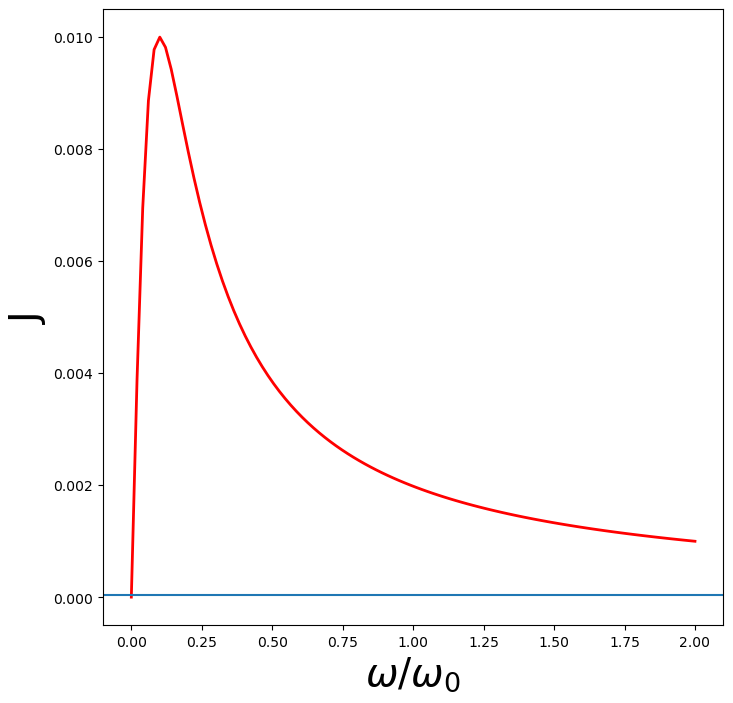

In [34]:
def plot_spectral_density():
    """ Drude-Lorentz spectral density muss zuerst in normale spectral density umgerechnet werden """
    wk = np.linspace(0, 2, 100)
    J = wk * 2 * lam * gamma / (gamma**2 + wk**2)
    J2=c/((w0-wk)**2+((gamma1**2) ))

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
    axes.plot(wk, J, 'r', linewidth=2)
    
    #axes.plot(wk, J2, 'b', linewidth=2)
    axes.set_xlabel(r'$\omega/\omega_0$', fontsize=28)
    axes.set_ylabel(r'J', fontsize=28)
    axes.axhline(0.006148**2)
plot_spectral_density()

plt.show()

/home/sander/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


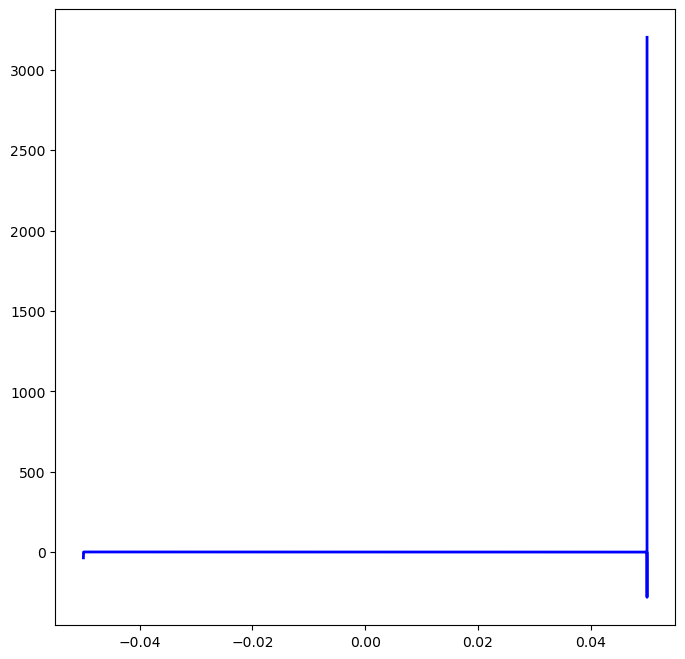

(0.04203457191616432-0.12934252575439253j)


In [35]:
tlist = np.linspace(-gamma/2,gamma/2, 99992+8)
#print( result_HEOM.e_data["21"])

x= result_HEOM.e_data["22"]
y = fft(x)
y = np.delete(y, 0)
tlist=np.delete(tlist, 0)
y = np.delete(y, 0)
tlist=np.delete(tlist, 0)
y = np.delete(y, 0)
tlist=np.delete(tlist, 0)
y = np.delete(y, 0)
tlist=np.delete(tlist, 0)
y = np.delete(y, 0)
tlist=np.delete(tlist, 0)
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(tlist, y, 'b', linewidth=2, label="Fourier")
plt.show()
print(y[9999])

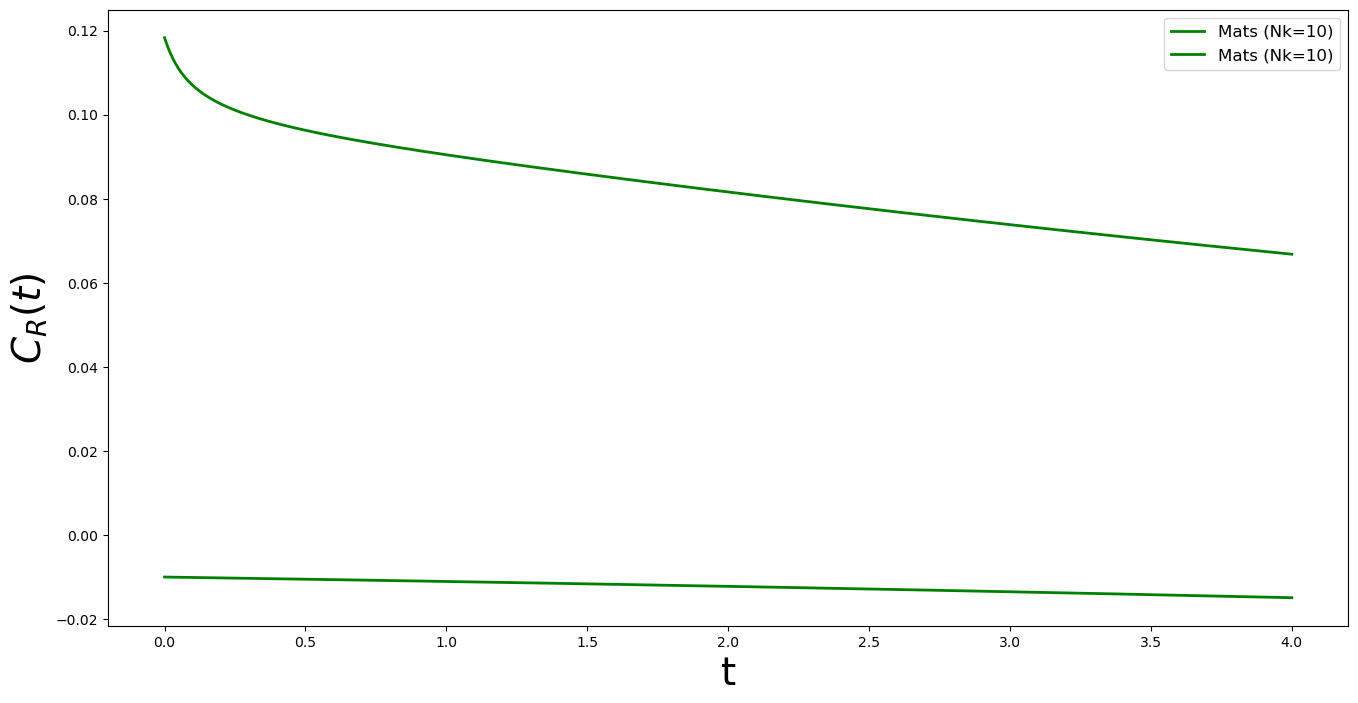

In [36]:
Del=g**2

tlist = np.linspace(0,4, 1000)
matsBath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
padeBath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)

# We will compare against a summation of {lmaxmats} Matsubara terms
lmaxmats = 15000
exactBath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=lmaxmats, combine=False)

# Real and imag. parts of the correlation functions:
def CR(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['R'] or exp.type == BathExponent.types['RI']:
            result += exp.ck * np.exp(-exp.vk * t)
    return result

def CI(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['I']:
            result += exp.ck * np.exp(exp.vk * t)
        if exp.type == BathExponent.types['RI']:
            result += exp.ck2 * np.exp(exp.vk * t)
    return result

fig, (ax1) = plt.subplots(ncols=1, sharey=True, figsize=(16, 8))

#ax1.plot(tlist, CR(exactBath, tlist), "r", linewidth=2, label=f"Mats (Nk={lmaxmats})")
ax1.plot(tlist, CR(Bad, tlist), "g", linewidth=2, label=f"Mats (Nk={Nk})")
#ax1.plot(tlist, CR(padeBath, tlist), "b--", linewidth=2, label=f"Pade (Nk={Nk})")
ax1.plot(tlist, CI(Bad, tlist), "g", linewidth=2, label=f"Mats (Nk={Nk})")
ax1.set_xlabel(r't', fontsize=28)
ax1.set_ylabel(r"$C_R(t)$", fontsize=28)
ax1.legend(loc=0, fontsize=12)

#tlist2=tlist[0:50]
#ax2.plot(tlist2, np.abs(CR(matsBath, tlist2) - CR(exactBath, tlist2)), "g", linewidth=2, label=f"Mats Error")
#ax2.plot(tlist2, np.abs(CR(padeBath, tlist2) - CR(exactBath, tlist2)), "b--", linewidth=2, label=f"Pade Error")

#ax2.set_xlabel(r't', fontsize=28)
#ax2.legend(loc=0, fontsize=12)
pass

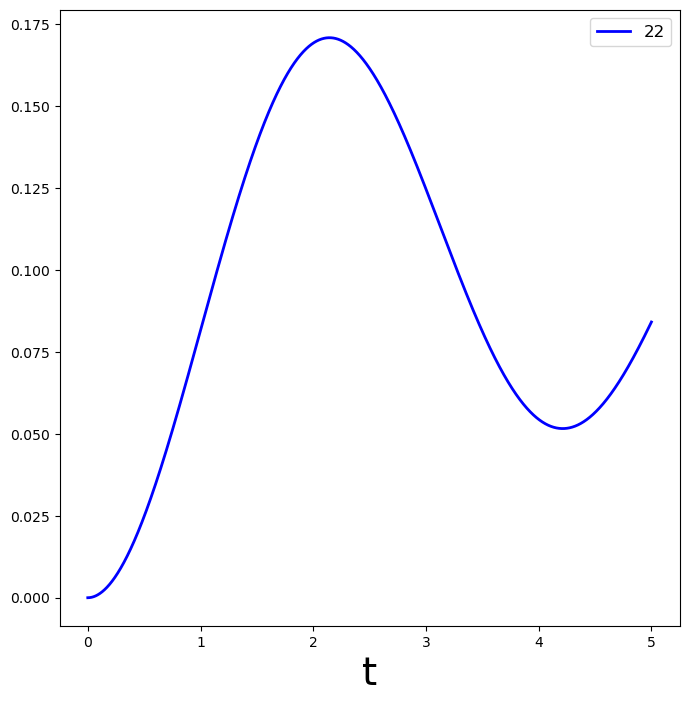

In [37]:
tlist = np.linspace(0, 100, 1000)
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(result_HEOM.times, result_HEOM.e_data["12"], 'b', linewidth=2, label="12")
#axes.plot(result_HEOM.times, np.imag(result_HEOM.e_data["21"]), 'r', linewidth=2, label="21")
#axes.plot(result_HEOM.times, result_HEOM.e_data["11"], 'g', linewidth=2, label="11")
axes.plot(result_HEOM.times, result_HEOM.e_data["11"], 'b', linewidth=2, label="22")
#axes.plot(result_HEOM.times, (np.abs(result_HEOM.e_data["E"]))**2, 'r', linewidth=2, label="E(t)²")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)
#plt.show()

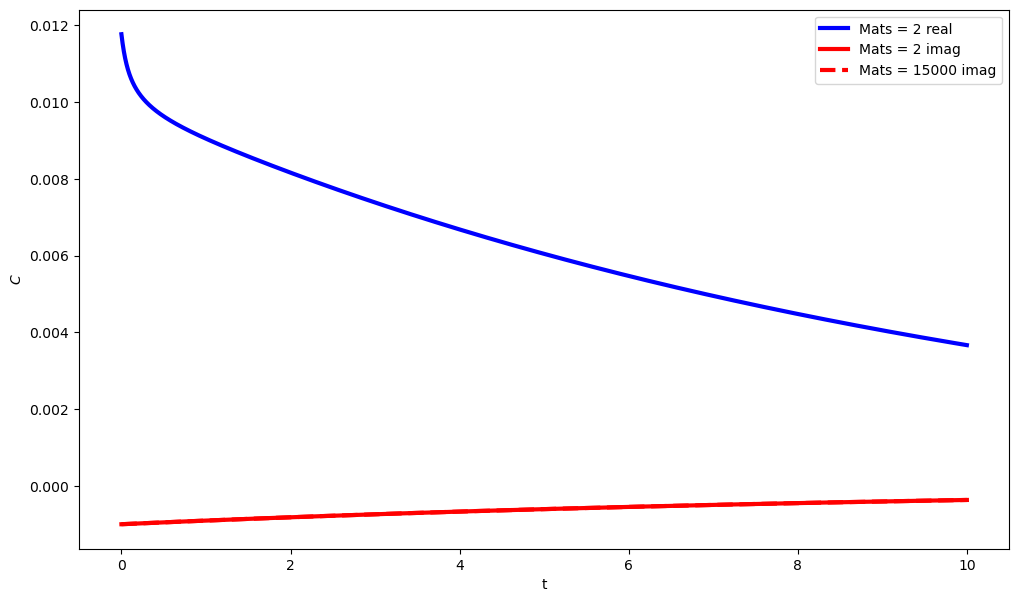

In [38]:
def dl_corr_approx(t, nk):
    """ Drude-Lorenz correlation function approximation.
    
        Approximates the correlation function at each time t to nk exponents.
    """
    
    c = lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t)*np.cosh( gamma*tl)**2
    for k in range(1, nk):
        vk = 2 * np.pi * k * T
        c += (4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(-vk * t)*np.cosh(vk*tl)**2
    return c


def plot_correlation_expansion_divergence(): 
    """ We plot the correlation function with a large number of Matsubara terms to show that
        the real part is slowly diverging at t = 0.
    """
    t = np.linspace(0, 10, 10000)
    # correlation coefficients with 15k and 2 terms
    corr_15k = dl_corr_approx(t, 15)
    corr_2 = dl_corr_approx(t, 10)

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.plot(t, np.real(corr_2), color="b", linewidth=3, label= r"Mats = 2 real")
    ax1.plot(t, np.imag(corr_2), color="r", linewidth=3, label= r"Mats = 2 imag")
    #ax1.plot(t, np.real(corr_15k), "b--", linewidth=3, label= r"Mats = 15000 real")
    ax1.plot(t, np.imag(corr_15k), "r--", linewidth=3, label= r"Mats = 15000 imag")

    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$C$")
    ax1.legend()
    
plot_correlation_expansion_divergence()

IndexError: list index out of range

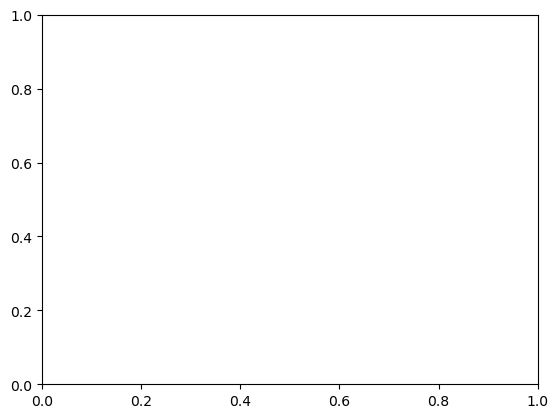

In [39]:
from Redfield import Redfield as Redfield 



def DrudeLorenz(wk): # Spektrale dichte mit Drude lorenz bad auch genannt timura terminator. 
    if wk==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *wk /(np.pi*(wk**2+gamma**2))) * ((1/(np.exp((wk) * beta)-1))+1)

    
    
redfield_solver = Redfield(H=H_sys, rho0=rho0, Q=Q, a=P21, ad=P21, w0=w0, gamma=gamma, lam=lam, tlist=tlist,spectrum=DrudeLorenz)

    # Löse das System
rho_t_redfield = redfield_solver.Rsolver()

    # Plotte die Ergebnisse
    
fig, ax = plt.subplots()
ax.plot(rho_t_redfield.times, rho_t_redfield.expect[0],label='Redfield')
ax.plot(result.times, result.expect[0],'g',label='Lindblad') # Lindblad
ax.plot(result_HEOM.times, result_HEOM.e_data["a"], label="HEOM") #HEOM
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
print(lam)

In [140]:
import numpy as np

# Parameter für die Korrelationsfunktion
gamma = 0.1  # Dämpfungsrate
omega_c = 1.0  # Charakteristische Frequenz (z.B. Schnittfrequenz des Bades)

# Lorentzförmige Korrelationsfunktion
def lorentz_correlation(t):
    return gamma * np.exp(-omega_c * np.abs(t))

# Zeitbereich für die Korrelationsfunktion
#tlist = np.linspace(0, 10, 100)

# Berechne die Korrelationsfunktion für die Zeitliste
C_t = lorentz_correlation(times)
bad4= BosonicBath(Q, C_t, vk_real, ck_imag, vk_imag)
solver = HEOMSolver(H_sys, Bad2, max_depth=max_depth, options=options)
# Plotten der Korrelationsfunktion
import matplotlib.pyplot as plt
plt.plot(tlist, C_t, label="Lorentz-Peak Correlation")
plt.xlabel("Time")
plt.ylabel("Correlation function")
plt.legend()
plt.show()

ValueError: The bath exponent lists ck_real and vk_real, and ck_imag and vk_imag must be the same length.

In [139]:
N = 2
w0 = 1.0 #* 2 * np.pi
#g = 0.1 * w0
#kappa = 0.15
times = np.linspace(0, 30, 200)

def DrudeLorenz(wk):
    if wk==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *wk /(np.pi*(wk**2+gamma**2))) * ((1/(np.exp((wk) * beta)-1))+1)

DL = (
    f"2*pi* 2.0 * {lam} / (pi * {gamma} * {beta}) if (w == 0) else "
    f"2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)"
)
options = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)


a = qutip.destroy(N)




res_brme = qutip.brmesolve(H_sys, rho0, times, ,e_ops=e_ops)

plt.figure()
#plt.plot(times, res_brme.expect[0], label=r'$a^{+}a$')
plt.plot(times, res_brme.expect[0], label=r'$a$')
plt.legend()
plt.show()

/home/sander/anaconda3/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


NameError: name 'w' is not defined

In [138]:
from Redfield import Redfield as Redfield 



def DrudeLorenz(wk): # Spektrale dichte mit Drude lorenz bad auch genannt timura terminator. 
    if wk==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *w /(np.pi*(w**2+gamma**2))) * ((1/(np.exp((w) * beta)-1))+1)

    
    
redfield_solver = Redfield(H=H_sys, rho0=rho0, Q=Q, a=a, ad=ad, w0=w, gamma=gamma, lam=lam, tlist=tlist,spectrum=DrudeLorenz)

    # Löse das System
rho_t_redfield = redfield_solver.Rsolver()

    # Plotte die Ergebnisse
    
fig, ax = plt.subplots()
ax.plot(rho_t_redfield.times, rho_t_redfield.expect[0],label='Redfield')
ax.plot(result.times, result.expect[0],'g',label='Lindblad') # Lindblad
ax.plot(result_HEOM.times, result_HEOM.e_data["a"], label="HEOM") #HEOM
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
print(lam)

NameError: name 'a' is not defined

    Parameters
    ----------
    H_sys : Qobj or QobjEvo or list
        The system Hamiltonian or Liouvillian. See :class:`HEOMSolver` for
        a complete description.

    coup_op : Qobj
        Operator describing the coupling between system and bath.
        See parameter ``Q`` in :class:`BosonicBath` for a complete description.

    coup_strength : float
        Coupling strength. Referred to as ``lam`` in :class:`DrudeLorentzBath`.

    temperature : float
        Bath temperature. Referred to as ``T`` in :class:`DrudeLorentzBath`.

    N_cut : int
        The maximum depth of the hierarchy. See ``max_depth`` in
        :class:`HEOMSolver` for a full description.

    N_exp : int
        Number of exponential terms used to approximate the bath correlation
        functions. The equivalent ``Nk`` in :class:`DrudeLorentzBath` is one
        less than ``N_exp`` (see note above).

    cut_freq : float
        Bath spectral density cutoff frequency. Referred to as ``gamma`` in
        :class:`DrudeLorentzBath`.

    bnd_cut_approx : bool
        Use boundary cut off approximation. If true, the Matsubara
        terminator is added to the system Liouvillian (and H_sys is
        promoted to a Liouvillian if it was a Hamiltonian). Keyword only.
        Default: False.

    options : dict, optional
        Generic solver options.
        If set to None the default options will be used. Keyword only.
        Default: None.

    combine : bool, default: True
        Whether to combine exponents with the same frequency (and coupling
        operator). See :meth:`BosonicBath.combine` for details.
        Keyword only. Default: True.
    """
    def __init__(
        self, H_sys, coup_op, coup_strength, temperature,
        N_cut, N_exp, cut_freq, *, bnd_cut_approx=False, options=None,
        combine=True,
    ):

In [ ]:
Stop 

NameError: name 'Stop' is not defined

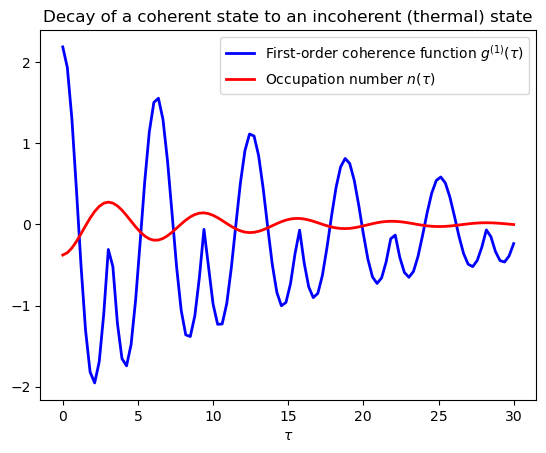

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip


N = 2
taus = np.linspace(0.0,tmax,nt)
a = qutip.destroy(N)
H = w  * a.dag() * a

# collapse operator
G1 = g**2
n_th = nB  # bath temperature in terms of excitation number
c_ops = [np.sqrt(G1 * (1 + n_th)) * a, np.sqrt(G1 * n_th) * a.dag()]

# start with a coherent state
rho0 = qutip.coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = qutip.mesolve(H, rho0, taus, c_ops, [a]).expect[0]

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = qutip.correlation_2op_1t(H, rho0, taus, c_ops, a.dag(), a)
g1 = np.array(G1) / np.sqrt(n[0] * np.array(n))

plt.plot(taus, np.real(g1), 'b', lw=2)
plt.plot(taus, n, 'r', lw=2)
plt.title('Decay of a coherent state to an incoherent (thermal) state')
plt.xlabel(r'$\tau$')
plt.legend([
    r'First-order coherence function $g^{(1)}(\tau)$',
    r'Occupation number $n(\tau)$',
])
plt.show()

[ 0.08005086+0.j          0.07960253+0.00806809j  0.07834367+0.01604586j
  0.07628776+0.02385208j  0.0734566 +0.03140738j  0.06987981+0.03863503j
  0.06559459+0.04546171j  0.06064532+0.05181826j  0.05508309+0.05764039j
  0.04896522+0.06286932j  0.04235458+0.06745237j  0.03531903+0.07134349j
  0.02793071+0.07450372j  0.02026525+0.07690161j  0.01240104+0.07851348j
  0.00441839+0.07932371j -0.0036012 +0.07932485j -0.01157601+0.07851771j
 -0.01942482+0.07691132j -0.02706777+0.07452286j -0.03442719+0.07137747j
 -0.04142839+0.06750795j -0.04800038+0.06295446j -0.05407663+0.05776408j
 -0.05959574+0.05199037j -0.06450203+0.04569273j -0.06874611+0.03893584j
 -0.07228541+0.03178906j -0.07508459+0.02432557j -0.07711588+0.01662175j
 -0.07835932+0.00875633j -0.07880307+0.00080965j -0.07844342-0.00713727j
 -0.07728482-0.01500345j -0.07533988-0.0227088j  -0.07262925-0.03017497j
 -0.0691813 -0.03732613j -0.0650319 -0.04408972j -0.06022405-0.05039725j
 -0.05480739-0.0561849j  -0.04883774-0.06139421j -0

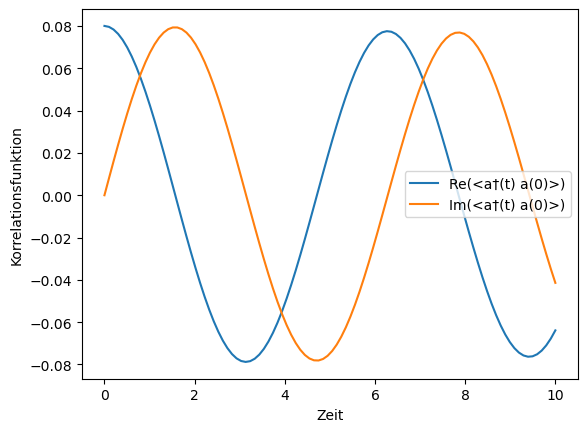

In [ ]:
from qutip import correlation_2op_1t, destroy, thermal_dm

import numpy as np
import matplotlib.pyplot as plt

# Parameter für das thermische Bad
N = 2  # Anzahl der Zustände
omega = w  # Frequenz des Systems
gamma2 = g**2  # Dämpfungsrate
beta = beta  # Inverse Temperatur (beta = 1/kT)

# Erzeuge den Vernichtungsoperator für das System
a = destroy(N)

# Thermischer Zustand des Systems
rho0 = thermal_dm(N, beta * omega)

# Hamiltonian des Systems (harmonischer Oszillator)
H = omega * a.dag() * a

# Lindblad-Operator (Dissipation)
L = np.sqrt(gamma2) * a

# Zeiten für die Berechnung der Korrelationsfunktion
times = np.linspace(0, 10, 100)

# Berechnung der Korrelationsfunktion <a†(t) a(0)> mit dem Hamiltonian H und Lindblad-Operator L
correlation_values = correlation_2op_1t(H, rho0, times, [L], a.dag(), a)
print(correlation_values)
# Ausgabe und Visualisierung der Korrelationsfunktion
plt.plot(times, np.real(correlation_values), label="Re(<a†(t) a(0)>)")
plt.plot(times, np.imag(correlation_values), label="Im(<a†(t) a(0)>)")
plt.xlabel('Zeit')
plt.ylabel('Korrelationsfunktion')
plt.legend()
plt.show()


In [ ]:
N_sys = 2
max_depth=2
nt = 100
tmax=30
tlist = [0, tmax, nt]
options = {"nsteps": 1500_000}
def proj(i, j):
    """ A helper function for creating an interaction operator. """
    return basis(N_sys, i) * basis(N_sys, j).dag()

# Construct one bath for each system state:
baths = []
for i in range(N_sys):
    Q = proj(i, i)
    baths.append(DrudeLorentzBath(Q, lam, gamma, T, Nk))

# Construct the system Liouvillian from the system Hamiltonian and
# bath expansion terminators:
H_sys = sum((i + 0.5) * w0* proj(i, i) for i in range(N_sys))
H_sys += sum(
  (i + j + 0.5) * g * proj(i, j)
  for i in range(N_sys) for j in range(N_sys)
  if i != j
)
HL = qutip.liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)

# Construct the solver (pass a list of baths):
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=options)

# Run the solver:
rho0 = basis(N_sys, 0) * basis(N_sys, 0).dag()
tlist = np.linspace(0, 5, 200)
e_ops = {
    f"P{i}": proj(i, i)
    for i in range(N_sys)
}
result = solver.run(rho0, tlist, e_ops=e_ops)

# Plot populations:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
for label, values in result.e_data.items():
    axes.plot(result.times, values, label=label)
axes.set_xlabel(r't', fontsize=28)
axes.set_ylabel(r"Population", fontsize=28)
axes.legend(loc=0, fontsize=12)

In [ ]:
#Bad underdumped 

def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1. / np.tanh(x)

def underdamped_matsubara_params(lam, gamma, T, nk):
    """ Calculation of the real and imaginary expansions of the underdamped correlation functions.
    """
    Om = np.sqrt(w0**2 - (gamma / 2)**2)
    Gamma = gamma / 2.
    beta = 1. / T

    ckAR = [
        (lam**2 / (4*Om)) * coth(beta * (Om + 1.0j * Gamma) / 2),
        (lam**2 / (4*Om)) * coth(beta * (Om - 1.0j * Gamma) / 2),
    ]
    ckAR.extend(
        (-2 * lam**2 * gamma / beta) * (2 * np.pi * k / beta) / 
        (((Om + 1.0j * Gamma)**2 + (2 * np.pi * k / beta)**2) *
         ((Om - 1.0j * Gamma)**2 + (2 * np.pi * k / beta)**2)) + 0.j
        for k in range(1, nk + 1)
    )
    vkAR = [
        -1.0j * Om + Gamma,
        1.0j * Om + Gamma,
    ]
    vkAR.extend(
        2 * np.pi * k * T + 0.j
        for k in range(1, nk + 1)
    )

    factor = 1. / 4

    ckAI = [
        -factor * lam**2 * 1.0j / Om,
        factor * lam**2 * 1.0j / Om,
    ]
    vkAI = [
        -(-1.0j * Om - Gamma),
        -(1.0j * Om - Gamma),
    ]
    
    return ckAR, vkAR, ckAI, vkAI

ckAR, vkAR, ckAI, vkAI = underdamped_matsubara_params(lam=lam, gamma=gamma, T=T, nk=Nk)

options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

def timer(label):
    """ Simple utility for timing functions:
    
        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")


Badunder = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
#HEOMMats = HEOMSolver(H_sys, Badunder, 5, options=options)
    

max_depth=4

#Gibt einen  ausdruck der zeit an. 

# times to evaluate the system state at
#result = solver.run(rho0, tlist)
# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()

# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):


# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()
E=basis(2,1) * basis(2,1).dag()*(basis(2,1) * basis(2,1).dag()).dag()
# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):
P12p = basis(2,0) * basis(2,1).dag()
P21p = basis(2,1) * basis(2,0).dag()
# Run the solver:


#result_HEOM = HEOMMats.run(rho0, tlist, e_ops={"22": P22p})

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(result_HEOM.times, result_HEOM.e_data["22"], 'b', linewidth=2, label="22")
#axes.plot(result_HEOM.times, (np.abs(result_HEOM.e_data["E"]))**2, 'r', linewidth=2, label="E(t)²")
    

import numpy as np
import matplotlib.pyplot as plt

# Parameter
gamma = 0.1  # Badkopplungsstärke
omega_c = 1.0  # Charakteristische Frequenz des Bades
dt = 0.01  # Zeitschritt
time = np.arange(0, 10, dt)  # Zeitachse
P_e = np.zeros_like(time)  # Wahrscheinlichkeit des angeregten Zustands
P_e[0] = 1.0  # Anfangswahrscheinlichkeit

# Korrelationsfunktion C(t)
def C(t):
    return gamma * np.cos(omega_c * t) * np.exp(-gamma * t) if t > 0 else 0

# Numerische Lösung der DGL
for k in range(1, len(time)):
    convolution = 0
    for j in range(k):
        convolution += C(time[k] - time[j]) * P_e[j] * dt
    P_e[k] = P_e[k - 1] - dt * convolution

# Plot
plt.plot(time, P_e, label="P_e(t)")
plt.xlabel("Zeit t")
plt.ylabel("Wahrscheinlichkeit P_e(t)")
plt.title("Lösung der DGL mit Faltung")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_13523/1753785462.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  P_e[k] = P_e[k-1]- dt*w0*1j*P_e[k-1]-dt* convolution


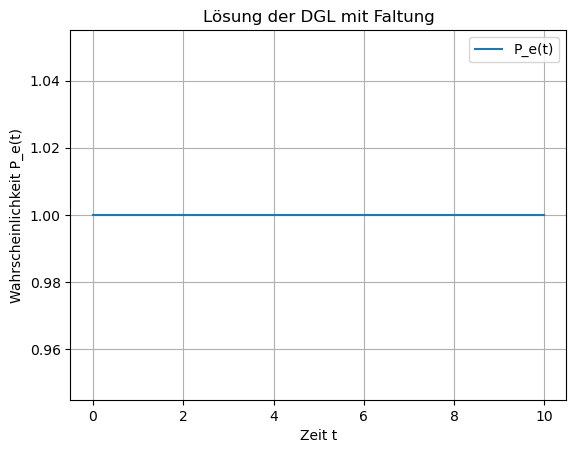

In [165]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
gamma = 0.1  # Badkopplungsstärke
omega_c = 1.0  # Charakteristische Frequenz des Bades
dt = 0.01  # Zeitschritt
time = np.arange(0, 10, dt)  # Zeitachse
P_e = np.zeros_like(time)  # Wahrscheinlichkeit des angeregten Zustands
P_e[0] = 1.0  # Anfangswahrscheinlichkeit

# Korrelationsfunktion C(t)
def C(t):
    return-0.5*1j*gamma*lam*(2*np.cosh(t*gamma)*(1 + np.cosh(Td*gamma)) + np.cosh((t - Td)*gamma)*(np.floor((np.pi - 2*np.angle(t - Td))/(4.*np.pi)) - np.floor(0.75 + np.angle(t - Td)/(2.*np.pi)))) if t >= 0 else 0
# Numerische Lösung der DGL
for k in range(1, len(time)):
    convolution = 0
    for j in range(k):
        convolution += C(time[k] - time[j]) * P_e[j] * dt
    P_e[k] = P_e[k-1]- dt*w0*1j*P_e[k-1]-dt* convolution

# Plot
plt.plot(time, np.abs(P_e)**2, label="P_e(t)")
plt.xlabel("Zeit t")
plt.ylabel("Wahrscheinlichkeit P_e(t)")
plt.title("Lösung der DGL mit Faltung")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_11393/3500429405.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  P_e[k] = P_e[k-1] -dt*w0*P_e[k-1]-dt* convolution[0]


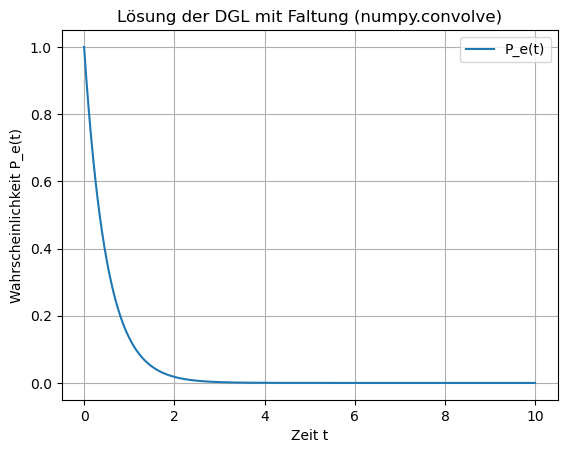

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
T=0
#lam = 0.1  # Badkopplungsstärke
#gamma = 0.4  # Charakteristische Frequenz des Bades
dt = 0.01  # Zeitschritt
time = np.arange(0, 10, dt)  # Zeitachse
P_e = np.zeros_like(time)  # Wahrscheinlichkeit des angeregten Zustands
P_e[0] = 1.0  # Anfangswahrscheinlichkeit
w0=1
# Korrelationsfunktion C(t)
def C(t):
    return -0.5*1j*gamma*lam*(2*np.cosh(t*gamma)*(1 + np.cosh(T*gamma)) + np.cosh((t - T)*gamma)*(np.floor((np.pi - 2*np.angle(t - T))/(4.*np.pi)) - np.floor(0.75 + np.angle(t - T)/(2.*np.pi)))) if t >= 0 else 0
# Diskretisiere die Korrelationsfunktion
C_vals = np.array([C(t) for t in time])

# Numerische Lösung der DGL
for k in range(1, len(time)):
    # Convolution with numpy.convolve
    convolution = np.convolve(C_vals[:k], P_e[:k], mode='valid') * dt
    P_e[k] = P_e[k-1] -dt*w0*P_e[k-1]-dt* convolution[0]

# Plot der Lösung
plt.plot(time, np.absolute(P_e)**2, label="P_e(t)")
plt.xlabel("Zeit t")
plt.ylabel("Wahrscheinlichkeit P_e(t)")
plt.title("Lösung der DGL mit Faltung (numpy.convolve)")
plt.legend()
plt.grid()
plt.show()

0.01


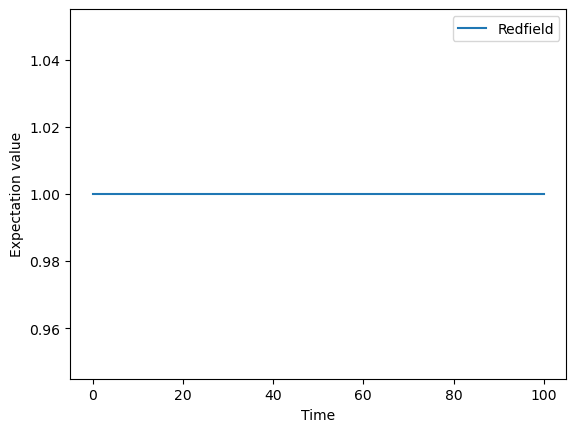

In [ ]:


from Redfield import Redfield as Redfield 
def DrudeLorenz(w): # Spektrale dichte mit Drude lorenz bad auch genannt timura terminator. 
    if w==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *w /(np.pi*(w**2+gamma**2))) * ((1/(np.exp((w) * beta)-1))+1)

    
    
redfield_solver = Redfield(H=H_sys, rho0=rho0, Q=P12+P21, a=P12, ad=P21, w0=w0, gamma=gamma, lam=lam, tlist=tlist,spectrum=DrudeLorenz,e_ops=P22)

    # Löse das System
rho_t_redfield = redfield_solver.Rsolver()

    # Plotte die Ergebnisse
    
fig, ax = plt.subplots()
ax.plot(rho_t_redfield.times, rho_t_redfield.expect[0],label='Redfield')

#ax.plot(result_HEOM.times, result_HEOM.e_data["a"], label="HEOM") #HEOM
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
print(lam)


[]


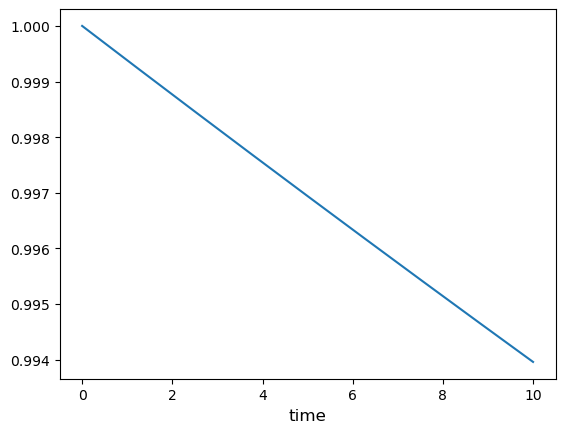

In [27]:
#!/bin/python3
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import qutip.solver.brmesolve as brmesolve
P22=basis(2,1) * basis(2,1).dag()
tlist = np.linspace(0, 10, 1000)
#lam=0.3
#beta=0.1
def DrudeLorenz(w): # Spektrale dichte mit Drude lorenz bad auch genannt timura terminator. 
    if w==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *w /(np.pi*(w**2+gamma**2))) * ((1/(np.exp((w) * beta)-1))+1)
DL = " 2*pi* 2.0 * {lam} / (pi * {gamma} * {beta})  if (w==0) else 2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)\".format(gamma=gamma, beta = beta, lam = lam)\n",
a_ops=[[P12+P21,DrudeLorenz]]
        
result=brmesolve(H_sys, rho0, tlist, a_ops, P22 ,args=None, sec_cutoff=0.1, options=None)
P22BR = expect(result.states, P22)
print(expect(result.states, P22))
plot_expectation_values([result]);
#plt.plot(tlist, np.real(P22BR), 'g--', linewidth=2, label="P22 Bloch Redfield")

In [ ]:

def C_p(ck, vk, zeit):
    # Konvertiere Eingaben in komplexe NumPy-Arrays
    ck = np.array(ck, dtype=np.complex256)
    vk = np.array(vk, dtype=np.complex256)
    # Ergebnisse für alle Zeiten berechnen
    Ct = []
    for t in zeit:
        # Vektorisierte Berechnung
        C = ck * np.exp(- vk * t)
        print(C)
        Csum = np.sum(C)  # Summe der Ergebnisse
        Ct.append(Csum)  # Speichere die Summe für diese Zeit
        
    return Ct
            

        
def Ctot():
    # Rufe die Methoden auf, um die Vektoren zu erhalten
    vec1 = C_p(ck_real,vk_real,tlist)
    vec2 = C_p(ck_imag,vk_imag,tlist)
    
    # Überprüfen, ob die Vektoren die gleiche Länge haben
    if len(vec1) != len(vec2):
        raise ValueError("Die Vektoren müssen die gleiche Länge haben.")
    
    # Indexweise Addition
    result = [np.abs((v1 -v2 ))for v1, v2 in zip(vec1, vec2)]
    return result

# Aufruf der Funktion
result = Ctot()